In [2]:
from ultralytics import YOLO
import cv2

In [32]:
def detect_and_annotate_potato(image_path, model_path="my_model.pt", confidence_threshold=0.4,):
    model = YOLO(model_path)
    image = cv2.imread(image_path)
    results = model.predict(source=image, conf=confidence_threshold, show=False)
    
    class_colors = {
        'Damaged Potato': (0, 0, 255),
        'Defected Potato': (255, 0, 0),
        'Potato': (0, 255, 0),
        'Sprouted Potato': (255, 255, 0)
    }

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    thickness_font = 5
    thickness = 2

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            label_name = model.names[cls_id]
            label = f"{label_name} ({conf:.2f})"
            color = class_colors.get(label_name, (255, 255, 255))
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            (text_w, text_h), _ = cv2.getTextSize(label, font, font_scale, thickness)
            cv2.rectangle(image, (x1, y1 - text_h - 10), (x1 + text_w, y1), color, -1)
            cv2.putText(image, label, (x1, y1 - 5), font, font_scale, (255, 255, 255), thickness_font)

    resized_image = cv2.resize(image, dsize=(640, 640), interpolation=cv2.INTER_NEAREST)
    cv2.imshow("Potato Detection", resized_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

detect_and_annotate_potato("images/test1.jpg")


0: 640x480 2 Potatos, 415.9ms
Speed: 9.6ms preprocess, 415.9ms inference, 14.5ms postprocess per image at shape (1, 3, 640, 480)


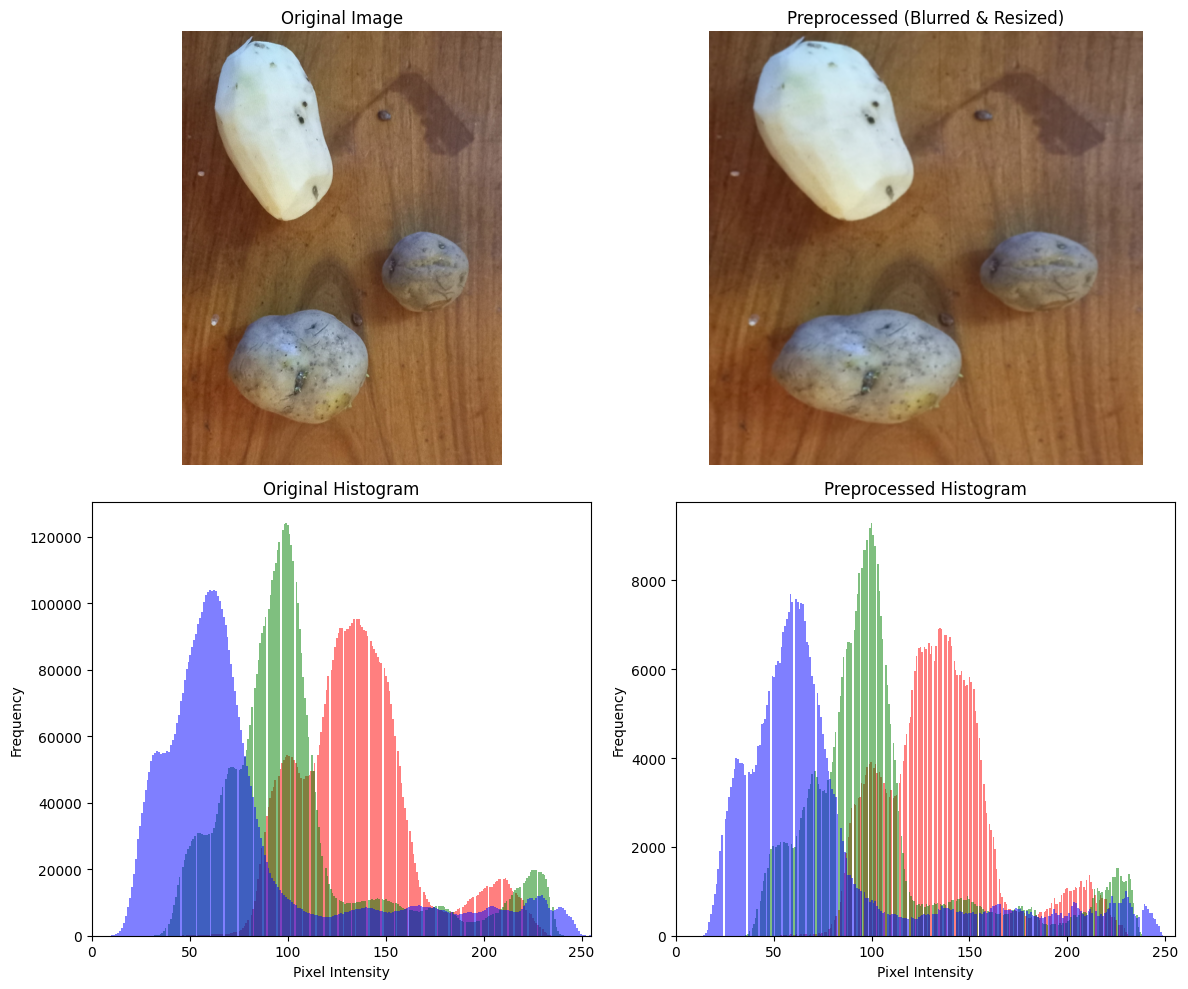


0: 640x640 1 Potato, 615.4ms
Speed: 11.6ms preprocess, 615.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


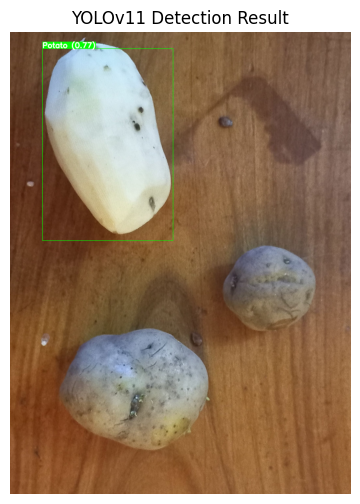

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def preprocess_image(image_path):
    # Load image in BGR format
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Resize to 640x640
    resized_image = cv2.resize(image_rgb, (640, 640))

    # Apply Gaussian Blur for noise reduction
    denoised_image = cv2.GaussianBlur(resized_image, (5, 5), 0)

    # Normalize for model input
    normalized_image = denoised_image / 255.0

    # Show original and preprocessed images with histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Show images
    axs[0, 0].imshow(image_rgb)
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(denoised_image)
    axs[0, 1].set_title("Preprocessed (Blurred & Resized)")
    axs[0, 1].axis("off")

    # Plot histograms
    for i, color in enumerate(['r', 'g', 'b']):
        axs[1, 0].hist(image_rgb[:, :, i].ravel(), bins=256, color=color, alpha=0.5)
        axs[1, 1].hist(denoised_image[:, :, i].ravel(), bins=256, color=color, alpha=0.5)

    axs[1, 0].set_title("Original Histogram")
    axs[1, 1].set_title("Preprocessed Histogram")

    for ax in axs[1]:
        ax.set_xlim([0, 255])
        ax.set_xlabel("Pixel Intensity")
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    return normalized_image, image_bgr  # Preprocessed (normalized RGB), original BGR

def detect_and_annotate_potato(preprocessed_image, original_image, model_path="my_model.pt", confidence_threshold=0.4):
    model = YOLO(model_path)

    # Convert normalized RGB to uint8 BGR for model input
    input_image = (preprocessed_image * 255).astype(np.uint8)
    input_bgr = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)

    # Run YOLO prediction
    results = model.predict(source=input_bgr, conf=confidence_threshold, show=False)

    # Colors for classes
    class_colors = {
        'Damaged Potato': (0, 0, 255),
        'Defected Potato': (255, 0, 0),
        'Potato': (0, 255, 0),
        'Sprouted Potato': (255, 255, 0)
    }

    # Get dimensions of original and preprocessed images
    orig_h, orig_w = original_image.shape[:2]
    proc_h, proc_w = input_bgr.shape[:2]  # Should be 640x640

    # Annotate on original image
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    thickness_font = 5
    thickness = 2

    for r in results:
        for box in r.boxes:
            # Get bounding box coordinates (for 640x640 preprocessed image)
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            label_name = model.names[cls_id]
            label = f"{label_name} ({conf:.2f})"
            color = class_colors.get(label_name, (255, 255, 255))

            # Scale coordinates to original image dimensions
            x1_orig = int(x1 * orig_w / proc_w)
            y1_orig = int(y1 * orig_h / proc_h)
            x2_orig = int(x2 * orig_w / proc_w)
            y2_orig = int(y2 * orig_h / proc_h)

            # Draw rectangle and text on original image
            cv2.rectangle(original_image, (x1_orig, y1_orig), (x2_orig, y2_orig), color, thickness)
            (text_w, text_h), _ = cv2.getTextSize(label, font, font_scale, thickness)
            cv2.rectangle(original_image, (x1_orig, y1_orig - text_h - 10), (x1_orig + text_w, y1_orig), color, -1)
            cv2.putText(original_image, label, (x1_orig, y1_orig - 5), font, font_scale, (255, 255, 255), thickness_font)

    # Convert BGR to RGB for displaying in matplotlib
    annotated_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(annotated_rgb)
    plt.title("YOLOv11 Detection Result")
    plt.axis("off")
    plt.show()

# Example usage
image_path = "images/test1.jpg"
preprocessed_image, original_image = preprocess_image(image_path)
detect_and_annotate_potato(preprocessed_image, original_image)